# Urban Systems Project: 
## Floor Space, Lot Density and Built Density in NYC

# I. Introduction

In this study we explore multiple variables to measure urban density of New York City. We use building data, tax lot data and census tract data to generate variables representing urban density. The City of New York publishes datasets on building, tax lot and census data; therefore the goal of this project is to explore available datasets, define variables and build a model to capture urban density in NYC. Then we compare these variables against the distance from the city center, which we defined as the location of the Empire State Building in midtown Manhattan. 

In [1]:
# Import modules for Python.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import pyplot as plt
import statsmodels.formula.api as smf
import seaborn as sns # seaborn not included in base Anaconda install
from IPython.display import Image, display, HTML
import requests
import zipfile
import io

### • Data Sources:
There are three datasets we used for this study:

__1) PLUTO Data:  
http://www1.nyc.gov/site/planning/data-maps/open-data/dwn-pluto-mappluto.page__  
New York City’s Primary Land User Tax Lot Output (PLUTO) is the dataset published by the Department of City Planning (DCP) with information on zoning, tax assessments and building features in five boroughs. Especially unique to PLUTO is that it provides detailed information for each tax lot such as land use, zoning, lot area, building footprint, building height, number of units, built year, zip code and Borough-Block-Lot ID (BBL). PLUTO also contains geospatial data for each lot, which allows further geospatial analysis and visualization in Geography Information System (GIS) applications such as Arc GIS 10.3 or CartoDB.

__2) NYC DOB Building Footprint Data:  
https://data.cityofnewyork.us/Housing-Development/Building-Footprints/nqwf-w8eh__  
Building footprint data is a GIS Shapefile of footprint outlines of buildings in New York City. It is a dataset published and maintained by the Department of Buildings (DOB) for construction permit, building inspection and violations.

__3) NYC Census Tract Data:  
http://www1.nyc.gov/site/planning/data-maps/open-data/districts-download-metadata.page__  
The DCP provides a GIS Shapefile of census tracts which maps all census tracts from the 2010 U.S. Census within the five boroughs of NYC. Census tracts generally include bodies of water, however the file we use has the boundaries clipped to shorelines and drops any census tracts that are all water.

# II. Data Cleaning and Munging:
### 1) PLUTO data

In [2]:
# Download, unzip, and import NYC PLUTO dataset as Pandas dataframe.
def zip_to_pandas(url, ext):
    r = requests.get(url)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    zipdf = pd.DataFrame()
    files = [f for f in z.namelist() if ext in f]
    print ("Beginning import...", end=" ")
    for f in files:
        print (f, end=" ")
        zipdf = zipdf.append(pd.read_csv(z.open(f), low_memory=False), ignore_index=True)
    return zipdf

plutourl = r'http://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/nyc_pluto_16v1.zip'
PLUTO = zip_to_pandas(plutourl, ".csv")

# Keep only the Pluto columns we need, we can discard the rest, also replace missing Census Tract values with zeros.
PLUTO = PLUTO[['BoroCode','CT2010','Block','BBL','LotArea','AssessLand','BldgArea','AllZoning1','LandUse']]
PLUTO['CT2010'].fillna(0, inplace=True)
PLUTO.dropna(inplace=True)

Beginning import... BK.csv BX.csv MN.csv QN.csv SI.csv 

In [3]:
# Generate a Census Tract code "BoroCT2010" by combining "BoroCode" and "CT2010" to join with census tract dataset later.
PLUTO['BoroCT2010'] = PLUTO['BoroCode']*1000000 + PLUTO['CT2010']*100
PLUTO.head(2)

,BoroCode,CT2010,Block,BBL,LotArea,AssessLand,BldgArea,AllZoning1,LandUse,BoroCT2010
0,3,21.0,1,3000010001,151930,1164645,0,M3-1/MX-2,11.0,3002100.0
1,3,21.0,1,3000010002,9620,389700,123199,M3-1,4.0,3002100.0


### 2) NYC DOB Building Footprint Data

In [4]:
dobcsv = r'https://dl.dropboxusercontent.com/s/mlqiycnymwap7yb/building_0316.csv'
BFP_BBL = pd.read_csv(dobcsv, header=0, usecols=[0,2,4,8,14], names=['BBL','BIN','YR','HEIGHT','FP_AREA'])
BFP_BBL = BFP_BBL[BFP_BBL.YR != 0]
BFP_BBL.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1070509 entries, 0 to 1082361
Data columns (total 5 columns):
BBL        1070509 non-null int64
BIN        1070509 non-null int64
YR         1070509 non-null int64
HEIGHT     1070509 non-null float64
FP_AREA    1070509 non-null float64
dtypes: float64(2), int64(3)
memory usage: 49.0 MB


In [5]:
# There can be multiple buildings on one lot, therefore we sum up the building footprint area per lot.
BBL_FP = BFP_BBL.groupby('BBL', as_index=False)['FP_AREA'].sum()
BBL_FP.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 808622 entries, 0 to 808621
Data columns (total 2 columns):
BBL        808622 non-null int64
FP_AREA    808622 non-null float64
dtypes: float64(1), int64(1)
memory usage: 18.5 MB


In [6]:
# Merge building footprints and PLUTO lots to aggregate all building area and lot information by BBL.
LOT_FP = pd.merge(PLUTO,BBL_FP, on='BBL',how = 'inner').drop(["BoroCode", "CT2010"], axis=1)
LOT_FP.columns = ['Block','BBL','LotArea','AssessLand','FloorSpace','Zoning','LandUse','BoroCT2010','FootPrint']
LOT_FP.head(2)

,Block,BBL,LotArea,AssessLand,FloorSpace,Zoning,LandUse,BoroCT2010,FootPrint
0,1,3000010050,19682,834300,154400,M1-4/R8A/MX-2,6.0,3002100.0,17683.475106
1,7,3000070021,10650,129600,9585,M3-1,10.0,3002100.0,8538.180616


In [7]:
LOT_FP_CT = LOT_FP.groupby('BoroCT2010', as_index=False)[['LotArea','FootPrint','FloorSpace','AssessLand']].sum()
LOT_FP_CT.head(2)

,BoroCT2010,LotArea,FootPrint,FloorSpace,AssessLand
0,1000000.0,3029425,277482.025225,478815,63316800
1,1000100.0,541886,104880.283396,541886,4225950


### 3) NYC Census Tract Data

In [8]:
# Read Census Tract Data from NYC Department of City Planning Open Data website:
cturl = r'https://data.cityofnewyork.us/api/views/h8hx-5cfk/rows.csv?accessType=DOWNLOAD'
CT = pd.read_csv(cturl, header=0, usecols=[5, 11], names=["BoroCT2010","SurfaceArea"])
CT = CT.groupby('BoroCT2010', as_index=False)['SurfaceArea'].sum()
CT.head(2)

,BoroCT2010,SurfaceArea
0,1000100,1.844421e+06
1,1000201,9.716282e+05


In [9]:
# Merge lot footprints aggregated by census tract with the surface area of each census tract. 
LOT_FP_LAND = pd.merge(LOT_FP_CT,CT, on='BoroCT2010',how = 'inner')
len(LOT_FP_LAND)

2156

In [10]:
# Drop bad values, keep only where surface area is bigger than lot area or lot area is bigger than building footprint area.
LOT_FP_LAND = LOT_FP_LAND[ (LOT_FP_LAND.SurfaceArea >= LOT_FP_LAND.LotArea) ]
LOT_FP_LAND = LOT_FP_LAND[ (LOT_FP_LAND.LotArea >= LOT_FP_LAND.FootPrint) ]
len(LOT_FP_LAND)

2122

# III. Methodology:
### 1) Calculate parameters for urban density
In order to measure density of NYC in multiple ways, we defined different parameters by aggregating across different datasets. There are some commonly used parameters such as Floor Area Ratio (FAR), however we wonder if there can be other variables to measure building density and urban land utilization. 

Therefore we define following parameters (figure below):

Variable| Definition    
--------- | ---------------
__T__         | ___T___otal Land Surface Area
__L__         | Total ___L___ot Area
__P__         | Total Building Foot ___P___rint Area
__S__         | Total Building Floor ___S___pace Area


$$Lot\;Density:\; l = \frac{L}{T}$$
$$Footprint\text{-}Lot\;Ratio:\; r = \frac{P}{L}$$
$$Floor\;Area\;Ratio:\; f = \frac{S}{L}$$
$$Foot\;Print\;Density:\; p = \frac{P}{T}$$
$$Floor\;Space\;Density:\; s = \frac{S}{T}$$

In [11]:
display(Image(url='https://dl.dropboxusercontent.com/s/1i3fbufjp9wahyw/Building-Density.png')) 

In [12]:
#Generate these parameters and add to our dataset.
LOT_FP_LAND['l'] = (LOT_FP_LAND.LotArea    / LOT_FP_LAND.SurfaceArea).round(decimals=4)
LOT_FP_LAND['r'] = (LOT_FP_LAND.FootPrint  / LOT_FP_LAND.LotArea).round(decimals=4)
LOT_FP_LAND['f'] = (LOT_FP_LAND.FloorSpace / LOT_FP_LAND.FootPrint).round(decimals=4)
LOT_FP_LAND['p'] = (LOT_FP_LAND.FootPrint  / LOT_FP_LAND.SurfaceArea).round(decimals=4)
LOT_FP_LAND['s'] = (LOT_FP_LAND.FloorSpace / LOT_FP_LAND.SurfaceArea).round(decimals=4)
LOT_FP_LAND.head(3)

,BoroCT2010,LotArea,FootPrint,FloorSpace,AssessLand,SurfaceArea,l,r,f,p,s
0,1000100.0,541886,104880.283396,541886,4225950,1.844421e+06,0.2938,0.1935,5.1667,0.0569,0.2938
2,1000202.0,1883187,465781.516904,3600089,64139424,3.315121e+06,0.5681,0.2473,7.7291,0.1405,1.0860
3,1000500.0,7736692,880393.137847,2725731,104445450,9.081808e+06,0.8519,0.1138,3.0960,0.0969,0.3001


In [13]:
#Calculate the average Floor Area Ratio (FAR) of NYC.
LOT_FP_LAND['FloorSpace'].sum()/LOT_FP_LAND['FootPrint'].sum()

3.1336028600746144

### 2) Density by Census Tract vs. Distance from the Center of NYC:

In [14]:
cartodburl = r'https://capellan.cartodb.com/api/v2/sql?format=CSV&q=SELECT%20*%20FROM%20nyct2010_density_dist'
Dist = pd.read_csv(cartodburl, header=0, usecols=[9,11,20], names=["boroname","BoroCT2010","dist_from_esb"])
Dist.head(2)

,boroname,BoroCT2010,dist_from_esb
0,Manhattan,1000100,6983.695477
1,Manhattan,1000201,3768.858540


In [15]:
final_data = pd.merge(LOT_FP_LAND, Dist, on='BoroCT2010', how='inner')
final_data = final_data[['BoroCT2010','boroname','LotArea','FootPrint','FloorSpace','SurfaceArea','dist_from_esb','s','p','f','l','r']]
final_data.head(3)

,BoroCT2010,boroname,LotArea,FootPrint,FloorSpace,SurfaceArea,dist_from_esb,s,p,f,l,r
0,1000100.0,Manhattan,541886,104880.283396,541886,1.844421e+06,6983.695477,0.2938,0.0569,5.1667,0.2938,0.1935
1,1000202.0,Manhattan,1883187,465781.516904,3600089,3.315121e+06,3752.552790,1.0860,0.1405,7.7291,0.5681,0.2473
2,1000500.0,Manhattan,7736692,880393.137847,2725731,9.081808e+06,6218.908678,0.3001,0.0969,3.0960,0.8519,0.1138


In [16]:
#We can export this dataset for more statistical analysis in Stata.
final_data.to_csv('Final_Dataset.csv')

# IV. Visualization:
### 1) New York City by Census Tracts:
Now we can visualize our parameters by census tract on maps. We use embedded CartoDB maps as our tool to visualize data. Click on "Visible layers" to switch between different parameters.

In [17]:
# Visualize all census tracts in NYC for multiple variables.
HTML('<iframe width="100%" height="520" frameborder="0" src="https://nyu.cartodb.com/u/yuan/viz/aa14b992-148a-11e6-b9f0-0ecd1babdde5/embed_map" allowfullscreen webkitallowfullscreen mozallowfullscreen oallowfullscreen msallowfullscreen></iframe>')

### 2) Manhattan by Census Tract, with tax lots and building footprints:
We can also examine Manhattan with a finer granularity to compare multiple variables we created.

In [18]:
#Plot Census Tract, tax lot and building footprint data on CartoDB for Manhattan.
HTML('<iframe width="100%" height="520" frameborder="0" src="https://nyu.cartodb.com/u/yuan/viz/24225582-145e-11e6-8669-0ecd1babdde5/embed_map" allowfullscreen webkitallowfullscreen mozallowfullscreen oallowfullscreen msallowfullscreen></iframe>')

### 3) Brooklyn by Census Tract, with tax lots and building footprints:

In [19]:
#Plot Census Tract, tax lot and building footprint data on CartoDB for Brooklyn.
HTML('<iframe width="100%" height="520" frameborder="0" src="https://nyu.cartodb.com/u/yuan/viz/46832ffa-14ce-11e6-a2e5-0e3ff518bd15/embed_map" allowfullscreen webkitallowfullscreen mozallowfullscreen oallowfullscreen msallowfullscreen></iframe>')

### 4) Plotting Data
Now we will plot data to visualize how different density parameters change with the distance from the city center. 

In [20]:
sns.set(style='ticks')
boro = final_data.boroname.sort_values().unique().tolist()
esblabel = 'Distance from Empire State Building (meters)'

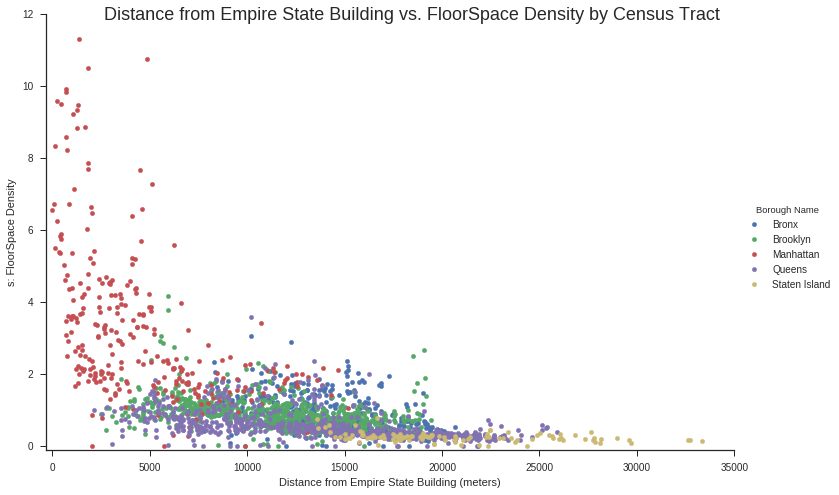

In [21]:
ax1 = sns.FacetGrid(data=final_data, hue='boroname', hue_order=boro, xlim=(-300,35000), ylim=(-0.1,12), aspect=1.5, size=7)
ax1.map(plt.scatter,'dist_from_esb','s').add_legend(title='Borough Name').set_axis_labels(esblabel, "s: FloorSpace Density")
ax1.fig.suptitle('Distance from Empire State Building vs. FloorSpace Density by Census Tract', fontsize=18);

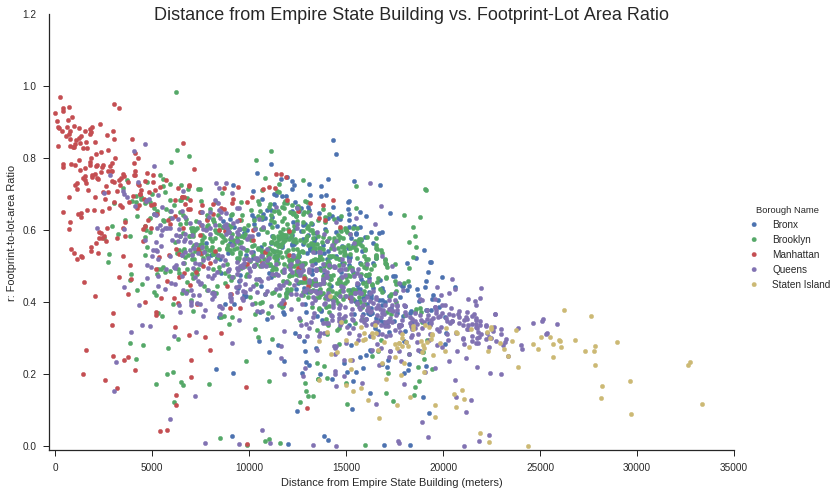

In [22]:
fg = sns.FacetGrid(data=final_data, hue='boroname', hue_order=boro, xlim=(-300,35000), ylim=(-0.01,1.2), aspect=1.5, size=7)
fg.map(plt.scatter,'dist_from_esb','r').add_legend(title = 'Borough Name').set_axis_labels(esblabel, "r: Footprint-to-lot-area Ratio")
fg.fig.suptitle('Distance from Empire State Building vs. Footprint-Lot Area Ratio', fontsize=18) ;

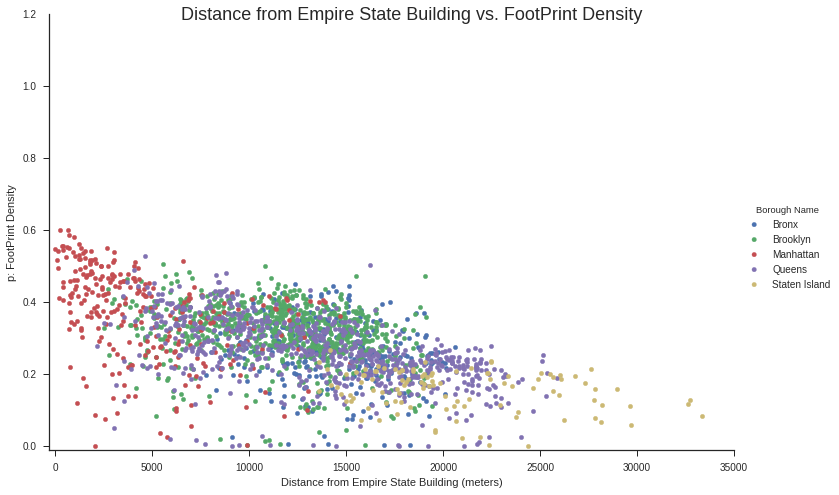

In [23]:
fg = sns.FacetGrid(data=final_data, hue='boroname', hue_order=boro, xlim=(-300,35000), ylim=(-0.01,1.2), aspect=1.5, size=7)
fg.map(plt.scatter,'dist_from_esb','p').add_legend(title = 'Borough Name').set_axis_labels(esblabel, "p: FootPrint Density")
fg.fig.suptitle('Distance from Empire State Building vs. FootPrint Density', fontsize=18);

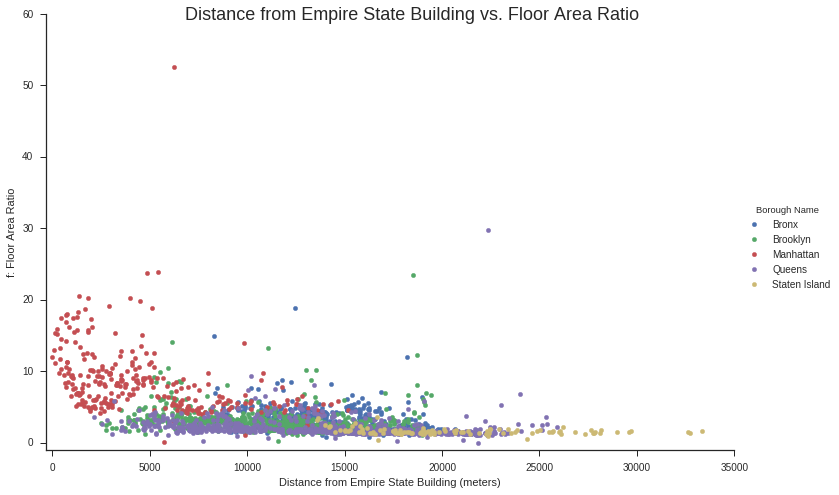

In [24]:
fg = sns.FacetGrid(data=final_data, hue='boroname', hue_order=boro, xlim=(-300,35000), ylim=(-1,60), aspect=1.5,size=7)
fg.map(plt.scatter,'dist_from_esb','f').add_legend(title = 'Borough Name').set_axis_labels(esblabel, "f: Floor Area Ratio")
fg.fig.suptitle('Distance from Empire State Building vs. Floor Area Ratio', fontsize=18); 

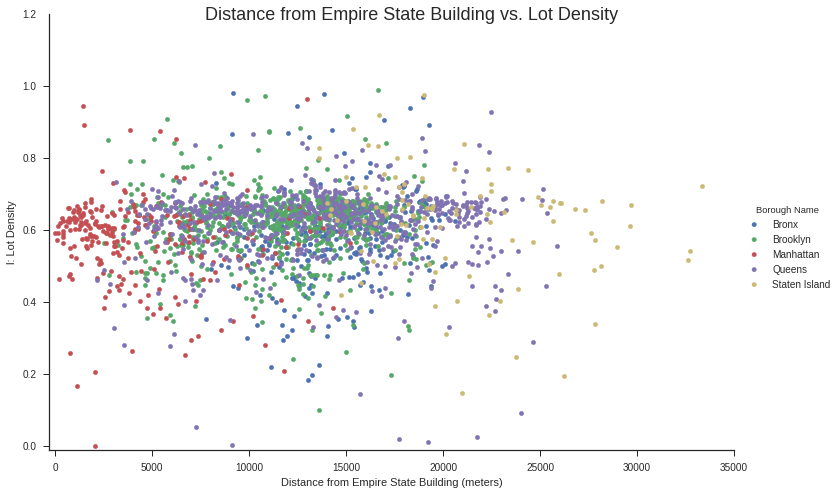

In [25]:
fg = sns.FacetGrid(data=final_data, hue='boroname', hue_order=boro, xlim=(-300,35000), ylim=(-0.01,1.2), aspect=1.5,size=7)
fg.map(plt.scatter,'dist_from_esb','l').add_legend(title = 'Borough Name').set_axis_labels(esblabel, "l: Lot Density")
fg.fig.suptitle('Distance from Empire State Building vs. Lot Density', fontsize=18);

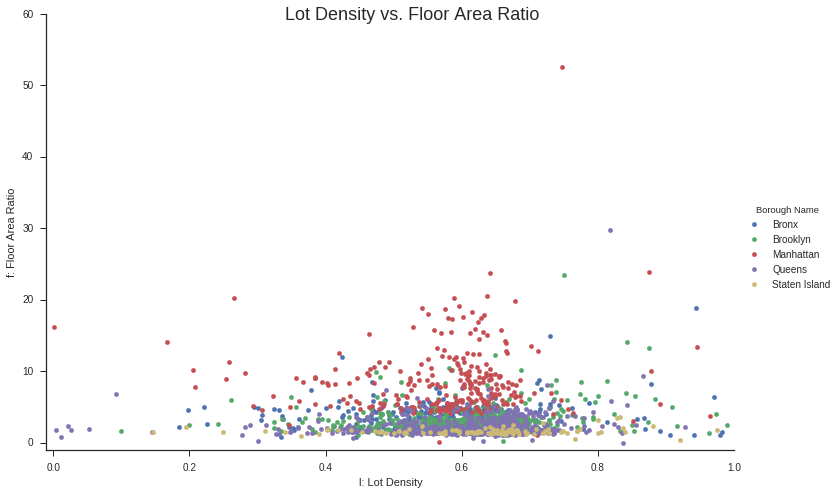

In [26]:
fg = sns.FacetGrid(data=final_data, hue='boroname', hue_order=boro, xlim=(-0.01,1), ylim=(-1,60), aspect=1.5, size=7)
fg.map(plt.scatter,'l','f').add_legend(title = 'Borough Name').set_axis_labels("l: Lot Density", "f: Floor Area Ratio")
fg.fig.suptitle('Lot Density vs. Floor Area Ratio', fontsize=18);

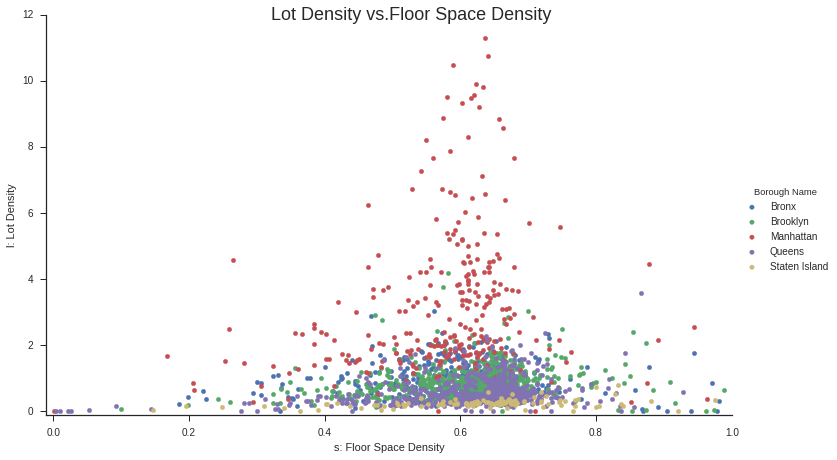

In [27]:
fg = sns.FacetGrid(data=final_data, hue='boroname', hue_order=boro, xlim=(-0.01,1), ylim=(-0.1,12), aspect=1.61,size=6.5)
fg.map(plt.scatter,'l','s').add_legend(title = 'Borough Name').set_axis_labels("s: Floor Space Density", "l: Lot Density")
fg.fig.suptitle('Lot Density vs.Floor Space Density', fontsize=18);

# V. Regression Analysis:

,s,p,f,l,r,dist_from_esb
s,,,,,,
p,0.581715,,,,,
f,0.817609,0.240001,,,,
l,0.00457733,0.18091,-0.0428905,,,
r,0.58751,0.886897,0.301783,-0.237326,,
dist_from_esb,-0.574299,-0.534363,-0.492634,0.064519,-0.583268,


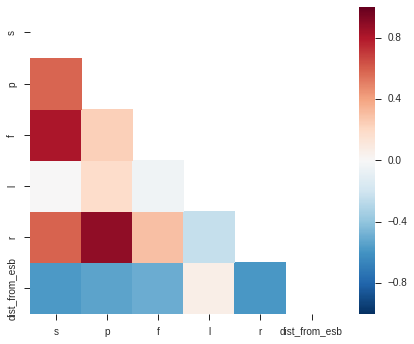

In [28]:
# Let's examine the correlation matrix.
final_data_corr =  final_data[['s','p','f','l','r','dist_from_esb']].corr()
mask = np.zeros_like(final_data_corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(final_data_corr, mask=mask, square=True);
final_data_corr.mask(np.triu(np.ones(final_data_corr.shape)).astype(np.bool)).replace(np.nan,"")

In [29]:
# Let's fit the logit.
mod = smf.ols(formula='dist_from_esb ~ s + p + f + l + r', data=final_data).fit()
print(mod.summary())

                            OLS Regression Results                            
Dep. Variable:          dist_from_esb   R-squared:                       0.455
Model:                            OLS   Adj. R-squared:                  0.454
Method:                 Least Squares   F-statistic:                     352.9
Date:                Mon, 09 May 2016   Prob (F-statistic):          1.95e-275
Time:                        16:38:40   Log-Likelihood:                -20622.
No. Observations:                2121   AIC:                         4.126e+04
Df Residuals:                    2115   BIC:                         4.129e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   2.425e+04   1135.982     21.344      0.0

In [30]:
# LOT_FP_LAND['pred'] = mod.predict()

# LOT_FP_LAND['diff'] = (LOT_FP_LAND.pred/LOT_FP_LAND.AssessLand)
# LOT_FP_LAND['diff'].describe()